In [1]:
# Necessary Imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from pymongo import MongoClient
from dotenv import load_dotenv
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from scipy.fft import fft
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
from generation import generate_gaze_points

# Load environment variables
load_dotenv()


True

In [2]:
key_width = 160 * 0.75

def generate_key_positions(win_width=2048, win_height=1152, key_width=160 * 0.75, key_height=160 * 0.75, horizontal_spacing=key_width * 0.25, vertical_spacing=200, num_points=100):
    top_row_y = win_height / 2 - vertical_spacing * 1.5
    middle_row_y = top_row_y - vertical_spacing
    bottom_row_y = middle_row_y - vertical_spacing

    row1_labels = ['Q', 'W', 'E', 'R', 'T', 'Y', 'U', 'I', 'O', 'P']
    row2_labels = ['A', 'S', 'D', 'F', 'G', 'H', 'J', 'K', 'L']
    row3_labels = ['Z', 'X', 'C', 'V', 'B', 'N', 'M']

    def calculate_start_x(num_keys):
        total_width = num_keys * key_width + (num_keys - 1) * horizontal_spacing
        return -total_width / 2 + key_width / 2

    def compute_key_positions(labels, start_x, y_pos):
        positions = []
        for i, label in enumerate(labels):
            x = start_x + i * (key_width + horizontal_spacing)
            positions.append((label, [x, y_pos]))
        return positions

    start_x_row1 = calculate_start_x(len(row1_labels))
    start_x_row2 = calculate_start_x(len(row2_labels))
    start_x_row3 = calculate_start_x(len(row3_labels))

    key_positions = {}
    for label, pos in compute_key_positions(row1_labels, start_x_row1, top_row_y):
        key_positions[label.upper()] = pos
    for label, pos in compute_key_positions(row2_labels, start_x_row2, middle_row_y):
        key_positions[label.upper()] = pos
    for label, pos in compute_key_positions(row3_labels, start_x_row3, bottom_row_y):
        key_positions[label.upper()] = pos

    key_positions['BOTAO_ACABAR'] = [0, bottom_row_y - vertical_spacing]

    return key_positions

positions = generate_key_positions()

In [19]:
from sklearn.model_selection import train_test_split

with open('words.txt', 'r') as f:
    words_list = f.readlines()
words_list = [word.strip() for word in words_list]
words_list = words_list

num_synthetic_samples_per_word = 100
num_points = 170
key_positions = positions  

import os
from pymongo import MongoClient
from comp_metric import get_last_n_gestures
client = MongoClient(os.getenv('MONGO_URI'))
db = client["wgaze"]
collection = db['batches']

# Fetch last 100 gestures
N = 200
last_300_gestures = get_last_n_gestures(db, 'batches', N)
real_gesture_words = []
real_gesture_data = []
for gesture in last_300_gestures:
    if gesture['word'] in words_list:
        real_gesture_words.append(gesture['word'])
        real_gesture_data.append(gesture['data'])
    else:
        continue 

len(real_gesture_words)

200

Extracting features...
Training the classifier...
Epoch [1/20], Training Loss: 4.5945, Validation Loss: 4.2820
Epoch [2/20], Training Loss: 3.0116, Validation Loss: 3.8082
Epoch [3/20], Training Loss: 1.7025, Validation Loss: 3.5098
Epoch [4/20], Training Loss: 0.9584, Validation Loss: 3.4217
Epoch [5/20], Training Loss: 0.5875, Validation Loss: 2.7829
Epoch [6/20], Training Loss: 0.3946, Validation Loss: 3.0761
Epoch [7/20], Training Loss: 0.2958, Validation Loss: 3.3100
Epoch [8/20], Training Loss: 0.2235, Validation Loss: 2.8281
Epoch [9/20], Training Loss: 0.1762, Validation Loss: 2.3121
Epoch [10/20], Training Loss: 0.1470, Validation Loss: 2.4958
Epoch [11/20], Training Loss: 0.1358, Validation Loss: 2.6584
Epoch [12/20], Training Loss: 0.1263, Validation Loss: 2.4770
Epoch [13/20], Training Loss: 0.1044, Validation Loss: 2.5893
Epoch [14/20], Training Loss: 0.0936, Validation Loss: 2.2698
Epoch [15/20], Training Loss: 0.0750, Validation Loss: 2.1540
Epoch [16/20], Training Loss:

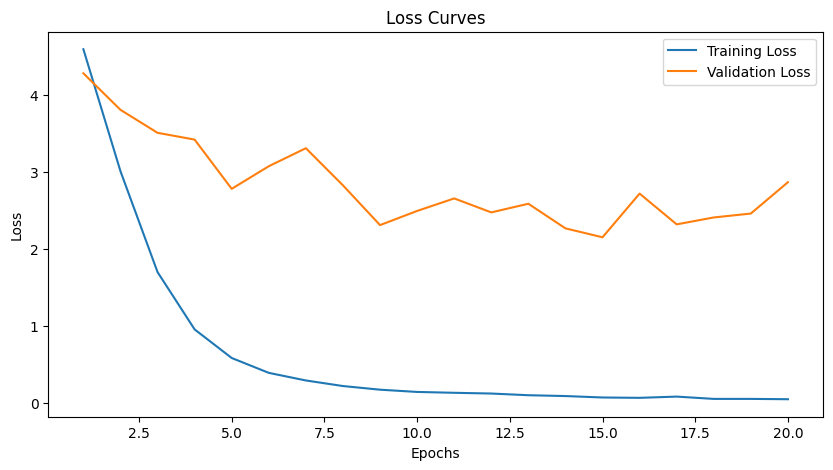

In [20]:
from sklearn.preprocessing import MinMaxScaler

synthetic_data =[]
synthetic_labels = []
for word in real_gesture_words:
    for _ in range(num_synthetic_samples_per_word):
        gaze_points = generate_gaze_points(word, key_positions, num_points)
        gaze_points = np.array(gaze_points)
        synthetic_data.append(gaze_points)
        synthetic_labels.append(word)

def pad_or_truncate(gaze_points, num_points):
    if gaze_points.shape[0] > num_points:
        return gaze_points[:num_points]
    else:
        num_points_to_add = num_points - gaze_points.shape[0]
        return np.concatenate((gaze_points, np.zeros((num_points_to_add, 2))))

real_gestures_processed = []
for data in real_gesture_data:
    gaze = np.array(data)
    gaze = pad_or_truncate(gaze, num_points)
    real_gestures_processed.append(gaze)

real_gestures_processed = np.array(real_gestures_processed)
synthetic_data = np.array(synthetic_data)
def normalize_data(data, min_val, max_val):
    return 2 * (data - min_val) / (max_val - min_val) - 1

all_key_positions_x = [pos[0] for pos in positions.values()]
all_key_positions_y = [pos[1] for pos in positions.values()]

min_x, max_x = min(all_key_positions_x), max(all_key_positions_x)
min_y, max_y = min(all_key_positions_y), max(all_key_positions_y)

synthetic_data = normalize_data(synthetic_data, min_x, max_x)
real_gestures_processed = normalize_data(real_gestures_processed, min_x, max_x)


def extract_features(gaze_points):
    x = gaze_points[:, 0]
    y = gaze_points[:, 1]


    features = np.concatenate((x, y))
    return features

print("Extracting features...")
synthetic_features = []
for gaze_points in synthetic_data:
    features = extract_features(gaze_points)
    synthetic_features.append(features)

real_features = []
for gaze_points in real_gestures_processed:
    features = extract_features(gaze_points)
    real_features.append(features)



label_encoder = LabelEncoder()
synthetic_labels_encoded = label_encoder.fit_transform(synthetic_labels)
real_labels_encoded = label_encoder.transform(real_gesture_words)

X_train, X_eval, y_train, y_eval = train_test_split(synthetic_features, synthetic_labels_encoded, test_size=0.2, random_state=42)


X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_eval = torch.tensor(real_features, dtype=torch.float32)
y_eval = torch.tensor(real_labels_encoded, dtype=torch.long)


class GazeDataset(Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



train_dataset = GazeDataset(X_train, y_train)
test_dataset = GazeDataset(X_eval, y_eval)


#cropei o subset de metade dos dados reais pra combinar pra usar no treino, e os outros 100 pra testar dps
test_to_combine = torch.utils.data.Subset(test_dataset, range(0, 100))
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, test_to_combine])

combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#continuo usando como validacao aq so os dados reais
eval_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



class ConvClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ConvClassifier, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        
        self.dropout = nn.Dropout(0.5)
        
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        
        self.fc = nn.Linear(128, num_classes)
            
    def forward(self, x):
        B, L = x.shape  # x tem forma (batch_size, seq_length)
        x = x.view(B, 1, L)  # Adiciona a dimensão de canal: (B, 1, L)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        
        x = self.dropout(x)
        
        x = self.global_avg_pool(x)  # Reduz para (B, 128, 1)
        x = x.view(B, -1)  # Achata para (B, 128)
        
        x = self.fc(x)  # Saída final (B, num_classes)
        
        return x


input_size = X_train.shape[1]
num_classes = len(label_encoder.classes_)
model = ConvClassifier(input_size, num_classes).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
training_loss = []
validation_loss = []

print("Training the classifier...")
for epoch in range(num_epochs):
    model.train()
    epoch_training_loss = 0
    for batch_X, batch_y in combined_loader:
        batch_X = batch_X.to('cuda')
        batch_y = batch_y.to('cuda')
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_training_loss += loss.item()
    avg_training_loss = epoch_training_loss / len(combined_loader)
    training_loss.append(avg_training_loss)

    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in eval_loader:
            batch_X = batch_X.to('cuda')
            batch_y = batch_y.to('cuda')
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            epoch_val_loss += loss.item()
    avg_val_loss = epoch_val_loss / len(eval_loader)
    validation_loss.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_training_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), training_loss, label='Training Loss')
plt.plot(range(1, num_epochs+1), validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

In [86]:
print(len(label_encoder.classes_))

200


tensor([112,  99,  83,  15, 139, 167, 197, 185,  73, 165,  74,  37,  71, 102,
        171,  49,  45, 161, 144, 155,  72, 115, 163,  77,  67, 114,  41,  42,
        123, 103,  82, 105])
tensor([ 91, 130,  31,  68,  85,  33,  90, 147, 176, 159,  79,  18,  28, 141,
        177, 157,  60, 198, 166, 181,  59, 132, 106, 153,  57, 107,  10, 149,
        179, 122, 120, 104])
tensor([184,  50, 199, 188, 116, 148,  89, 117, 183,  80,   6,  84,  98,  61,
        191,  20, 186,  12,  44,  14,   5, 170,  11, 145, 136,  97,  76, 174,
         95, 195,  32, 119])
tensor([62, 23, 58,  8])
Validation Accuracy: 0.5800
Training Accuracy: 0.9862
(108, 108)


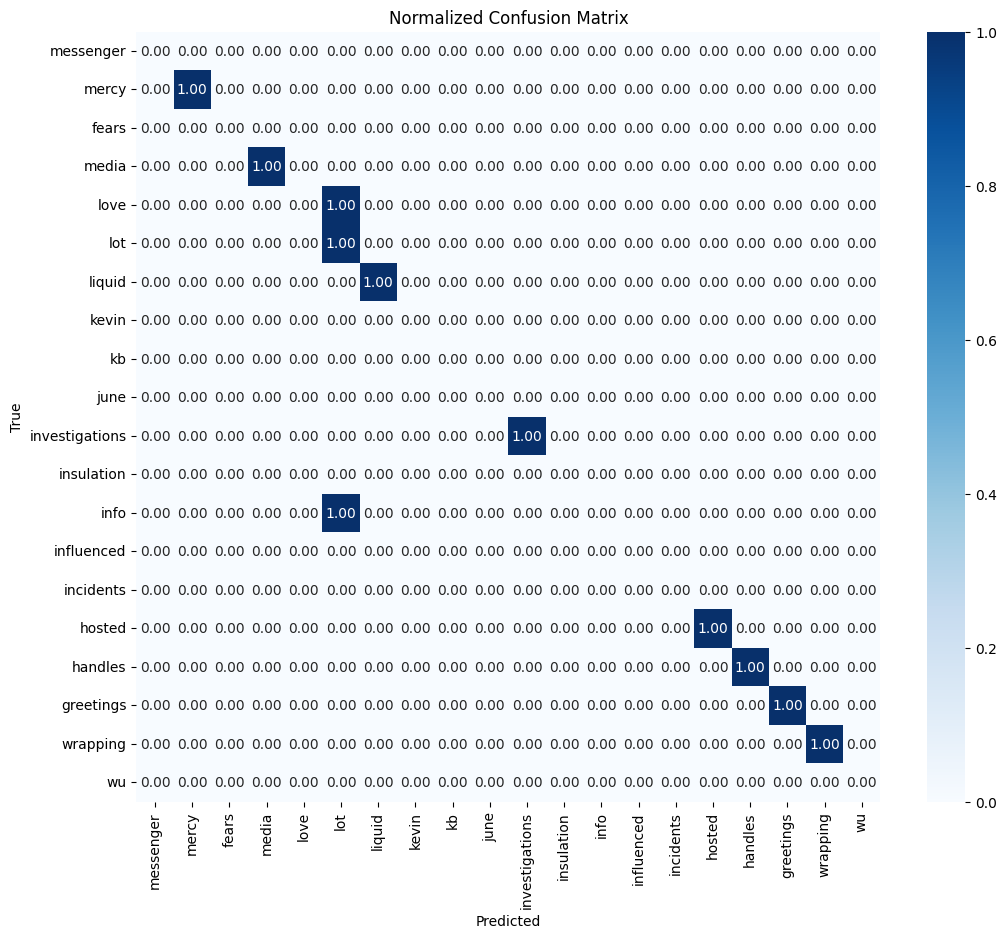

In [21]:

model.eval()
y_true = []
y_pred = []
y_true_train = []
y_pred_train = []

eval_subset = torch.utils.data.Subset(test_dataset, range(100,))
eval_subset_loader = DataLoader(eval_subset, batch_size=32, shuffle=False)

with torch.no_grad():
    for batch_X, batch_y in eval_subset_loader:
        print(batch_y)
        batch_X = batch_X.to('cuda')
        batch_y = batch_y.to('cuda')
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(batch_y.tolist())
        y_pred.extend(predicted.tolist())

with torch.no_grad():
    for batch_X, batch_y in combined_loader:
        batch_X = batch_X.to('cuda')
        batch_y = batch_y.to('cuda')
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        y_true_train.extend(batch_y.tolist())
        y_pred_train.extend(predicted.tolist())


accuracy = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")
accuracy_train = accuracy_score(y_true_train, y_pred_train)
print(f"Training Accuracy: {accuracy_train:.4f}")



cm = confusion_matrix(y_true, y_pred)
print(cm.shape)

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()


top_n = 20
class_counts = np.bincount(y_true)
top_n_classes_idx = np.argsort(class_counts)[-top_n:]
top_n_classes = label_encoder.inverse_transform(top_n_classes_idx)
cm_top_n = confusion_matrix(y_true, y_pred, labels=top_n_classes_idx)
plot_confusion_matrix(cm_top_n, top_n_classes)

In [66]:
#print number of parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 11231112


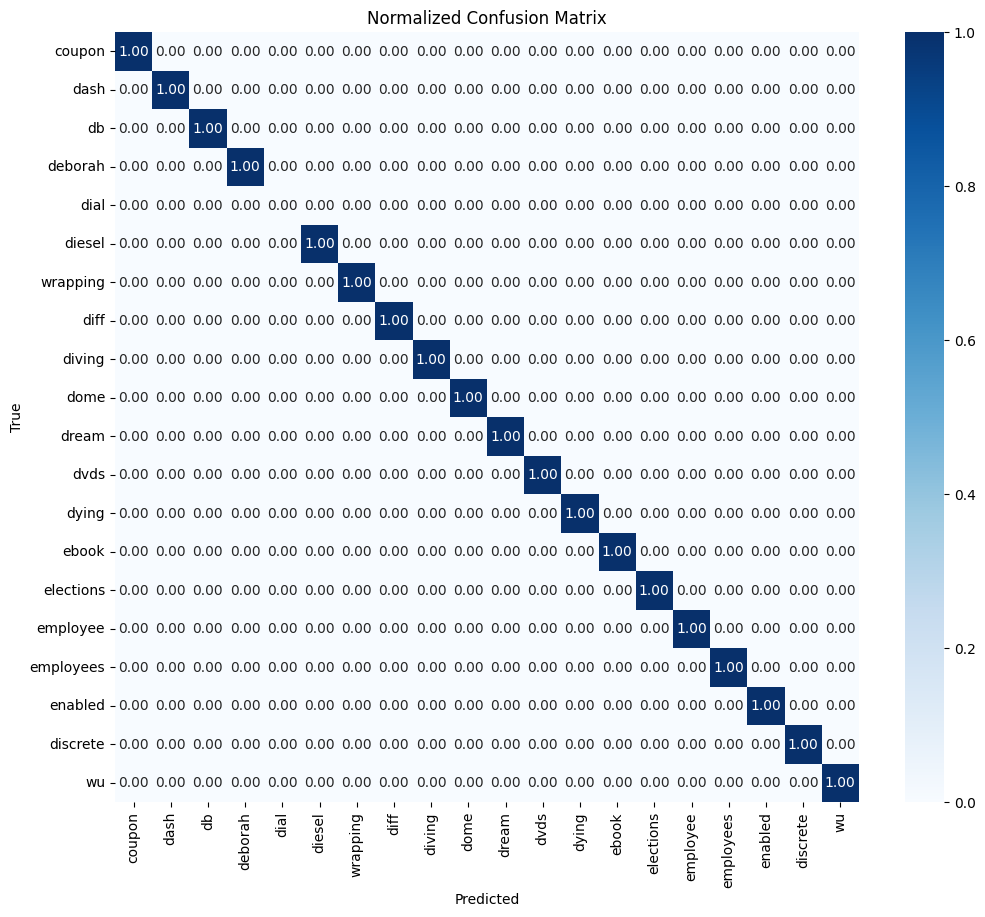

In [67]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()


top_n = 20  
class_counts = np.bincount(y_true)
top_n_classes_idx = np.argsort(class_counts)[-top_n:]
top_n_classes = label_encoder.inverse_transform(top_n_classes_idx)

cm_top_n = cm[np.ix_(top_n_classes_idx, top_n_classes_idx)]

plot_confusion_matrix(cm_top_n, top_n_classes)

In [88]:
model_path = 'models/gaze_classifier_real_1.pth'
torch.save(model.state_dict(), model_path)